#  Pruebas con IBM Quantum Platform Classic.

![Imagen introduccion](assets/ibm_logo.png
)

---


#### Criptografía y comunicaciones seguras. Ciberseguridad. Aleatoriedad cuántica real.

---

#### **Autor:** *Héctor Ayuso Martín*

# Generador de números aleatorios cuánticos (QRNG)

![Imagen introduccion](assets/random.webp
)

*"Aleatoriedad"*, o lo que una IA entiende por ello.

Vamos a hacer algo más práctico y avanzado con computación cuántica. Dado que ya se ha realizado en cuadernillos anteriores experimentos con el estado GHZ, podemos construir un proyecto con utilidad práctica.

La idea es hacer un QNRG, utilizando la QPU ibm_brisbane.

La generación de números aleatorios reales es una herramienta muy práctica para la ciberseguridad, la criptografía y las simulaciones. Las bibliotecas de clase Random, que utilizamos en distintos lenguajes de programación, realmente no generan números aleatorios reales. Es pseudo-aleatoriedad. Estas bibliotecas usan un seed (semilla) para generar secuencias de números extremedamente grandes, pero que terminan repitiendose, por que no hay aleatoriedad real.


Haciendo uso de la computación cuántica, podemos acercarnos mucho más a esa realidad.

###  Pero antes: Aleatoriedad clásica con Python

In [ ]:
#Vamos a producir numeros pseudo-aleatorios del 1 al 10:

import random

#Si configuramos el seed o semilla a un número x, la aparición de números pseudo-aleatorios siempre seguirá la misma secuencia.

random.seed(1010)

print('Secuencia de números aleatorios con el seed marcado en 1010.')
print('')


for i in range(10):
    
    numero_aleatorio = random.randint(1,10)
    
    print(numero_aleatorio)
print('')
print('===================================================================================')
print('')

#Si ejecutamos esta celda varias veces, podemos comprobar que la secuencia de números generada es la misma siempre, debido al valor del seed. Si cambiamos el seed, la secuencia
#avanzara o se retrasará.

import time

random.seed(time.time())

print('Secuencia de números aleatorios con el valor seed variable, basado el la hora(time).')
print('')

for i in range(10):
    
    numero_aleatorio_2 = random.randint(1,10)
    
    print(numero_aleatorio_2)


Secuencia de números aleatorios con el seed marcado en 1010

10
4
9
2
7
7
7
3
3
7


Secuencia de números aleatorios con el valor seed variable, basado el la hora(time)

3
4
2
1
4
7
5
6
8
4


## QRNG. Números aleatorios reales, fuente cuántica.

In [12]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

import configparser
import matplotlib.pyplot as plt

import numpy as np
from scipy.stats import entropy


### 1: Carga y configuración de la cuenta de IBM.

In [13]:
def cuenta_ibm():
    """Configura la carga de la cuenta IBM y API KEY. Retorna service (QiskitRuntimeService)"""
    
    config = configparser.ConfigParser()
    config.read('config.ini')
    api_key = config['IBM']['api_key']
    QiskitRuntimeService.save_account(token=api_key, channel='ibm_quantum', overwrite= True)
    return QiskitRuntimeService()

### 2: Selección del Backend y preparación del circuito.

In [14]:
def prepare_qrng_circuit(num_bits=8):
    """Prepara un circuito cuántico para generar números aleatorios."""
    
    qc = QuantumCircuit(num_bits, num_bits)
    for i in range(num_bits):
        qc.h(i)  # Aplicamos puerta Hadamard a cada qubit.
        qc.measure(i, i)  # Medimos cada qubit.
    return qc

Este circuito cuántico se utiliza para generar números aleatorios aprovechando la naturaleza probabilística de la mecánica cuántica. 

La función crea un circuito con un número determinado de qubits y registros clásicos. En cada qubit se aplica la puerta Hadamard, lo que lo coloca en un estado de superposición (|0⟩ + |1⟩)/√2, es decir, cada qubit tiene igual probabilidad de colapsar a 0 o 1 al ser medido. 

Luego, se miden todos los qubits y se almacena el resultado en el registro clásico correspondiente. De esta manera, la medición de cada qubit produce un bit aleatorio, y la concatenación de estos bits forma el número aleatorio. Al utilizar un proceso intrínsecamente cuántico, se obtiene una fuente de verdadera aleatoriedad, a diferencia de los generadores pseudoaleatorios clásicos.

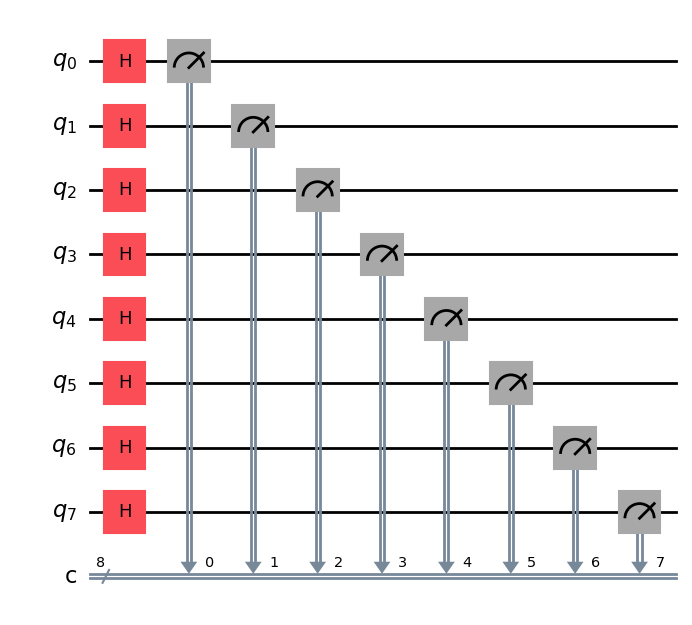

In [15]:
circuito = prepare_qrng_circuit()
circuito.draw('mpl')


### 3: Enviamos el circuito a IBM_Brisbane.

In [16]:
def run_qrng_on_ibm(qc, backend_name='ibm_kyiv'):
    """Ejecuta el circuito cuántico en un backend real de IBM Quantum."""
    
    service = cuenta_ibm()
    backend = service.backend(backend_name)
    qc_transpiled = transpile(qc, backend)
    sampler = Sampler(backend)
    job = sampler.run([qc_transpiled])
    return job

### 4: Obtenemos el resultado del backend

In [17]:
def get_qrng_result(job, num_bits):
    """Obtiene los resultados de medición y los convierte en un número binario."""
    result = job.result()
    counts = result.get_counts()  # Método correcto para obtener los conteos de medidas.
    measured_bits = max(counts, key=counts.get)  # Tomar el resultado más frecuente.
    return format(int(measured_bits, 2), f'0{num_bits}b')


---

---

### 5: Ejecutamos.

In [ ]:
#1.1 Cargar la cuenta de IBM Quantum.
service = cuenta_ibm()
print('Configuración cargada con exito.')

Configuración cargada con exito


In [ ]:
#2.1 Preparar el circuito para un número de bits específico.
num_bits = 8  
qc = prepare_qrng_circuit(num_bits)
print('Circuito cuántico preaparado con exito.')
qc.draw('mpl')


Circuito cuántico preaparado con exito


<Figure size 872.774x785.944 with 1 Axes>

In [ ]:
#3.1 Enviar el circuito a IBM Quantum y obtener el ID del trabajo.
job = run_qrng_on_ibm(qc)
print("ID del trabajo enviado:", job.job_id(), ', exito!.')

ID del trabajo enviado: cz1v5ne39f40008ryt70 Exito!


Enlace a IBM: https://quantum-computing.ibm.com


In [ ]:
#4.1 Recuperar el resultado cuando haya terminado
job_result = job.result()
counts = job_result[0].join_data().get_counts() # Obtiene los coteos de medición.
most_common = max(counts, key=counts.get) # Extrae el bitstring más frecuente.
print(f"Número aleatorio generado ({num_bits} bits): {most_common}")

Número aleatorio generado (8 bits): 11110101


---

### 6: Evaluaciones.

#### Funciones de evaluación de la aleatoriedad del número obtenido:

1<> Entropía de Shannon

2<> Prueba de Monobit

3<> Autocorrelación


In [189]:
# <> 1

def compute_entropy(bitstring):
    """Calcula la entropía de Shannon del conjunto de bits."""
    
    values, counts = np.unique(list(bitstring), return_counts=True)
    return entropy(counts, base=2)


In [190]:
# <> 2

def monobit_test(bitstring):
    """Prueba Monobit: analiza el balance entre 0s y 1s."""
    ones = bitstring.count('1')
    zeros = bitstring.count('0')
    return abs(ones - zeros) / len(bitstring)  # Diferencia relativa entre 1s y 0s



In [191]:
# <> 3

def autocorrelation_test(bitstring):
    """Prueba de Autocorrelación: detecta patrones repetitivos en la secuencia."""
    shifted = bitstring[1:] + bitstring[0]  # Desplazamos la secuencia 1 bit
    matches = sum(1 for i in range(len(bitstring)) if bitstring[i] == shifted[i])
    return matches / len(bitstring)  # Proporción de coincidencias con la secuencia desplazada

#### Ejecución de la evaluación:


In [201]:
en = compute_entropy(most_common)
monobit = monobit_test(most_common)
auto_corr = autocorrelation_test(most_common)

print(f"\nEvaluación de Aleatoriedad del numero obtenido por IBM Quantum: {most_common}")
print('')
print(f"Entropía de Shannon: {en:.4f}")
print('====================================================')
print(f"Prueba Monobit (balance de 0s y 1s): {monobit:.4f}")
print('====================================================')
print(f"Prueba de Autocorrelación: {auto_corr:.4f}")


Evaluación de Aleatoriedad del numero obtenido por IBM Quantum: 11110101

Entropía de Shannon: 0.8113
Prueba Monobit (balance de 0s y 1s): 0.5000
Prueba de Autocorrelación: 0.5000


El número obtenido (11110101) a partir de IBM Quantum ha sido evaluado en términos de aleatoriedad mediante varias pruebas. 

La entropía de Shannon, que mide la incertidumbre en la distribución de bits, se calculó en 0.8113, lo que indica una buena diversidad en la información. 

La prueba monobit, que evalúa el balance entre ceros y unos, muestra un valor de 0.5000, evidenciando una distribución equitativa de ambos dígitos. 

La prueba de autocorrelación también arroja un valor de 0.5000, lo que sugiere la ausencia de patrones o correlaciones significativas entre bits adyacentes. 

Estos resultados respaldan la calidad aleatoria del número, lo cual es esencial para aplicaciones criptográficas y simulaciones estocásticas.

---

#### Por último, usamos el número aleatorio como seed en nuestro futuro programa:

In [ ]:
#5.0 Añadimos el número cuántico generado por la brisbane como Seed para el uso de la pseudo_aleatoriedad a partir de este punto.
import random 

random.seed(most_common)

#Por ultimo, generamos una [lista] con 30 números aleatorios del 0 al 10.
lista_aleatoria = []

for i in range(30):
    lista_aleatoria.append(random.randint(0,10))
    
print(lista_aleatoria)

[6, 4, 8, 0, 2, 1, 3, 7, 2, 2, 8, 6, 5, 6, 5, 5, 4, 0, 10, 2, 7, 8, 3, 4, 2, 8, 6, 4, 0, 0]


Este fragmento de código utiliza un número cuántico previamente obtenido en la ibm_brisbane (almacenado en la variable most_common) para inicializar el generador pseudoaleatorio de Python mediante random.seed(most_common). Al hacerlo, se garantiza que la secuencia de números que se genere a partir de esa semilla tenga un origen basado en verdadera aleatoriedad al ser de origen cuántico. A continuación, se emplea un bucle para generar 30 números enteros aleatorios en el rango de 0 a 10, los cuales se almacenan en una lista. Esta técnica permite obtener una secuencia de números que es reproducible si se utiliza la misma semilla, o bien completamente distinta al cambiar el valor de random_bits, facilitando así el equilibrio entre aleatoriedad real y capacidad de replicación en el experimento.

---

---

In [23]:
print("Lista de las QPUs de IBM disponibles:")
print('')
for qpu in service.backends():
    print(qpu)
    print('')
    

    

Lista de las QPUs de IBM disponibles:

<IBMBackend('ibm_brisbane')>

<IBMBackend('ibm_kyiv')>

<IBMBackend('ibm_sherbrooke')>



![Imagen introduccion](assets/flag.png
)

> Barcelona, 2 de Marzo de 2025